# Getting started


In this tutorial, we use a General Linear Model (GLM) to compare the fMRI signal during periods of auditory stimulation
versus periods of rest.

The analyse described here is performed in the native space, directly on the original scans without any spatial or temporal preprocessing.
As we discussed in class during the lecture, preprocessing is important, and more sensitive results would likely be obtained on the corrected, spatially normalised and smoothed images.
The preprocessing step is skipped here so that we can focus on the GLM component of the analysis.

## Data

The dataset comes from an experiment conducted at the FIL by Geraint Rees under the direction of Karl Friston. It is provided by FIL methods group which develops the SPM software.

According to SPM documentation, 96 scans were acquired (repetition time TR = 7s) in one run. 
The paradigm consisted of alternating periods of stimulation and rest, lasting 42s each (that is, for 6 scans).
The run started with a rest block.
Auditory stimulation consisted of bi-syllabic words presented binaurally at a rate of 60 per minute.
The functional data starts at scan number 4, that is the image file ``fM00223_004``.

The whole brain BOLD/EPI images were acquired on a 2T Siemens MAGNETOM Vision system. Each scan consisted of 64 contiguous slices (64x64x64 3mm x 3mm x 3mm voxels).
Acquisition of one scan took 6.05s, with the scan to scan repeat time (TR) set arbitrarily to 7s.

## Retrieving the data

<div class="alert alert-info"><h4>Note</h4><p>Here, we load the data using a data downloading
          function. If you were analysing your own data, you would need to provide
          a list of paths to your own files in the ``subject_data`` variable.
          These should abide to the Brain Imaging Data Structure
          (BIDS) organization.</p></div>

In [1]:
from nilearn.datasets import fetch_spm_auditory

subject_data = fetch_spm_auditory()
print(*subject_data.func[:5], sep="\n")  # print paths of first 5 func images

/Users/dperrin/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img
/Users/dperrin/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img
/Users/dperrin/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img
/Users/dperrin/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img
/Users/dperrin/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img


We can display the first functional image and the subject's anatomy:



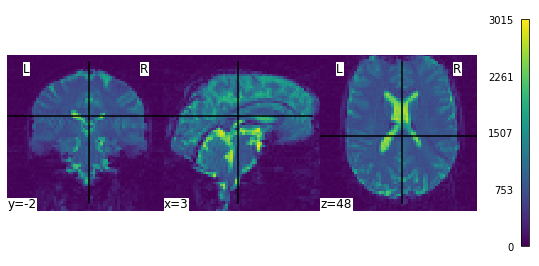

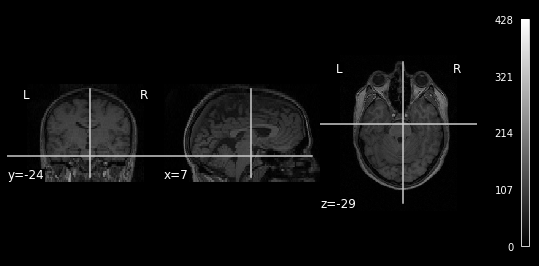

In [2]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

plot_img(subject_data.func[0], colorbar=True, cbar_tick_format="%i")
plot_anat(subject_data.anat, colorbar=True, cbar_tick_format="%i")

Next, we concatenate all the 3D EPI images into a single 4D image, then we average them in order to create a background
image that will be used to display the activations:

In [3]:
from nilearn.image import concat_imgs, mean_img

fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

# Specifying the experimental paradigm

We must now provide a description of the experiment, that is, define the timing of the auditory stimulation and rest periods.
This is typically provided in an events.tsv file.
The path of this file is provided in the dataset.

In [4]:
import pandas as pd

events = pd.read_table(subject_data["events"])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


# Performing the GLM analysis

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix* using the information provided by the ``events`` object.

In [5]:
from nilearn.glm.first_level import FirstLevelModel

Parameters of the first-level model:
* t_r=7(s) is the time of repetition of acquisitions
* noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
* standardize=False means that we do not want to rescale the time series to mean 0, variance 1
* hrf_model='spm' means that we rely on the SPM "canonical hrf" model (without time or dispersion derivatives)
* drift_model='cosine' means that we model the signal drifts as slow oscillating time functions
* high_pass=0.01(Hz) defines the cutoff frequency (inverse of the time period).

In [6]:
fmri_glm = FirstLevelModel(
    t_r=7,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

Now that we have specified the model, we can run it on the fMRI image.

In [7]:
fmri_glm = fmri_glm.fit(fmri_img, events)

One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [10]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is implictily meant to for multiple runs.

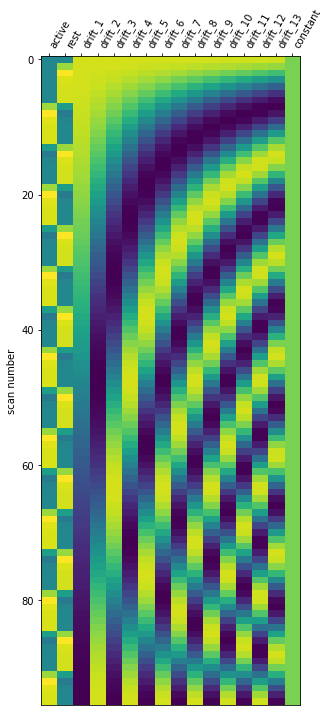

In [11]:
import matplotlib.pyplot as plt

from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix)

plt.show()

Save the design matrix image to disk first create a directory where you want to write the images:

In [12]:
from pathlib import Path

output_dir = Path.cwd() / "results" / "plot_single_subject_single_run"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

plot_design_matrix(design_matrix, output_file=output_dir / "design_matrix.png")

Output will be saved to: /Users/dperrin/Documents/Work/Teaching/IFN646/wk09/results/plot_single_subject_single_run


The first column contains the expected response profile of regions which are
sensitive to the auditory stimulation.
Let's plot this first column



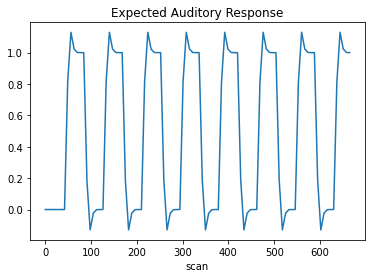

In [13]:
plt.plot(design_matrix["active"])
plt.xlabel("scan")
plt.title("Expected Auditory Response")
plt.show()

# Detecting voxels with significant effects

To access the estimated coefficients (Betas of the GLM model), we created a contrast with a single '1' in each of the columns.
The role of the contrast is to select some columns of the model --and potentially weight them-- to study the associated statistics. 
So in a nutshell, a contrast is a weighted combination of the estimated effects.
Here we can define canonical contrasts that just consider the two effects in isolation ---let's call them "conditions"---
then a contrast that makes the difference between these conditions.

In [14]:
import numpy as np

conditions = {"active": np.zeros(16), "rest": np.zeros(16)}
conditions["active"][0] = 1
conditions["rest"][1] = 1

We can then compare the two conditions 'active' and 'rest' by defining the corresponding contrast:

In [15]:
active_minus_rest = conditions["active"] - conditions["rest"]

Let's look at it: plot the coefficients of the contrast indexed by the names of the columns of the design matrix.

<Axes: label='conditions'>

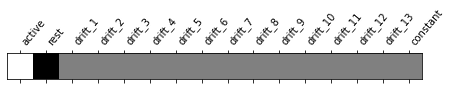

In [16]:
from nilearn.plotting import plot_contrast_matrix

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

Below, we compute the 'estimated effect'.
It is in BOLD signal unit, but has no statistical guarantees, because it does not take into account the associated variance.

In [17]:
eff_map = fmri_glm.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

In order to get statistical significance, we form a t-statistic, and directly convert it into z-scale.
The z-scale means that the values are scaled to match a standard Gaussian distribution (mean=0, variance=1), across voxels, if there were no effects in the data.

In [18]:
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")

# Plot thresholded z scores map

We display it on top of the average functional image of the series (could be the anatomical image of the subject).
We use arbitrarily a threshold of 3.0 in z-scale.
We'll see later how to use corrected thresholds. 
We will show 3 axial views, with display_mode='z' and cut_coords=3.

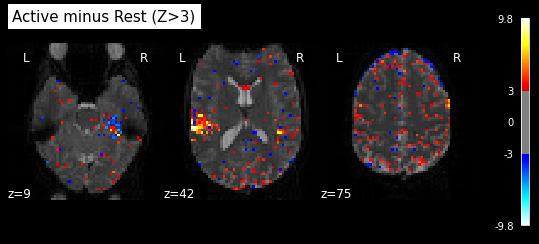

In [19]:
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=3.0,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

# Statistical significance testing

One should worry about the statistical validity of the procedure: here we used an arbitrary threshold of 3.0 but the threshold should provide some guarantees on the risk of false detections (aka type-1 errors in statistics).

One suggestion is to control the false positive rate (FPR, denoted by alpha) at a certain level, for instance 0.001.
This means that there is 0.1% chance of incorrectly declaring an inactive voxel, active.

Uncorrected p<0.001 threshold: 3.291


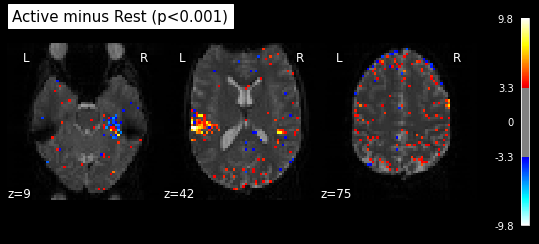

In [20]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.001)",
)
plt.show()

The problem is that with this you expect 0.001 * n_voxels to show up while they're not active --- tens to hundreds of voxels. 
A more conservative solution is to control the family wise error rate, i.e. the probability of making only one false detection, say at 5%.
For that we could use the so-called Bonferroni correction.

Bonferroni-corrected, p<0.05 threshold: 4.934


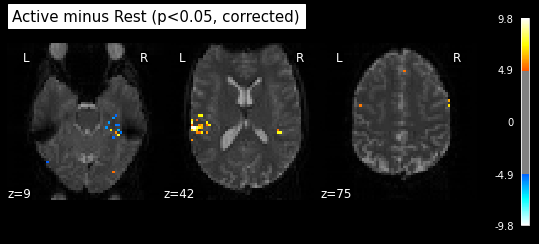

In [21]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.05, corrected)",
)
plt.show()

This is quite conservative indeed!
A popular alternative is to control the expected proportion of false discoveries among detections.
This is called the False discovery rate.

False Discovery rate = 0.05 threshold: 2.904


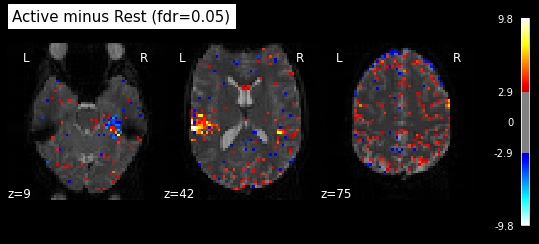

In [22]:
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05)",
)
plt.show()

Finally people like to discard isolated voxels (aka "small clusters") from these images. 
It is possible to generate a thresholded map with small clusters removed by providing a cluster_threshold argument.
Here clusters smaller than 10 voxels will be discarded.

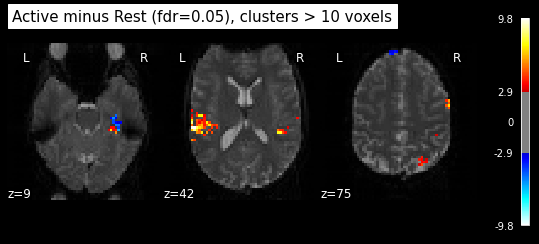

In [23]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

We can save the effect and zscore maps to the disk.

In [24]:
z_map.to_filename(output_dir / "active_vs_rest_z_map.nii.gz")
eff_map.to_filename(output_dir / "active_vs_rest_eff_map.nii.gz")

We can furthermore extract and report the found positions in a table.



In [25]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.811979,4050
1,1a,-63.0,6.0,36.0,8.601922,
2,1b,-63.0,0.0,42.0,8.435063,
3,1c,-48.0,-15.0,39.0,8.364058,
4,2,60.0,0.0,36.0,9.605128,1512
5,2a,45.0,-12.0,42.0,7.590200,
6,3,63.0,12.0,27.0,8.253889,972
7,3a,51.0,3.0,30.0,6.968355,
8,3b,54.0,9.0,39.0,3.565609,
9,4,36.0,-3.0,15.0,8.087451,1188


This table can be saved for future use.



In [26]:
table.to_csv(output_dir / "table.csv")

# Performing an F-test

"active vs rest" is a typical t-test: condition versus baseline.
Another popular type of test is an F-test in which one seeks whether a certain combination of conditions (possibly two-,
three- or higher-dimensional) explains a significant proportion of the signal.
Here one might for instance test which voxels are well explained by the combination of the active and rest condition.

We need to specify the contrast and compute the corresponding map.
Actually, the contrast specification is done exactly the same way as for t-contrasts:

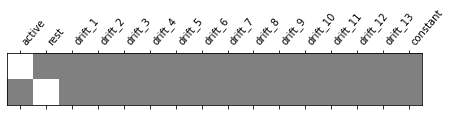

In [27]:
effects_of_interest = np.vstack((conditions["active"], conditions["rest"]))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

z_map = fmri_glm.compute_contrast(effects_of_interest, output_type="z_score")

Note that the statistic has been converted to a z-variable, which
makes it easier to represent it.



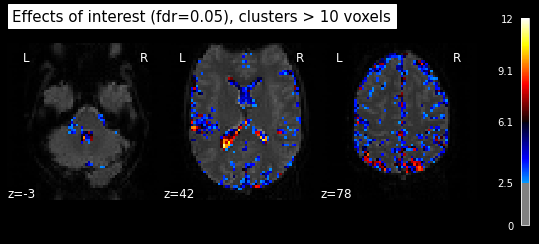

In [28]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

In this example, there is a lot of non-neural signal in there (ventricles, arteries).
It would have to be cleaned out (but this is a different topic).